# NOTEBOOK 6b: ANALISI COUNTERFACTUALS


- fare (df con y_min, y_white, differenza e poi) media differenza per tutti i modelli  

In [1]:
# IMPORTING STATEMENTS
import sys
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


np.random.seed(7)


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.1.1
Scikit-Learn 1.2.2
GPU is available


# Import Data and Preparation

In [2]:
# DF FINALE 

counterf = pd.read_csv('TEST_DATA.csv')

In [3]:
# Import Predictions
path = 'predictions/'    # path of folder

In [4]:
models = ['LinearRegression', 'RandomForest', 'XGBoost', 'LightGBM','HybridModel','Stacking']
y_preds = []

for model in models:
    y_preds.append( pd.read_csv(str(path)+str(model)+'_pred.csv', header=None).loc[:,0])

In [5]:
y_preds[0]

0       1.869147e+10
1       1.869147e+10
2       1.869147e+10
3       1.869147e+10
4       1.869147e+10
            ...     
2245    3.664430e+00
2246   -1.869147e+10
2247    3.703522e+10
2248    3.460476e+00
2249    4.094324e+00
Name: 0, Length: 2250, dtype: float64

In [6]:
counterf.reset_index(drop=True, inplace=True)

In [7]:
y_true = counterf.pop('InterestRate') 

In [8]:
y_true

0       4.500
1       5.000
2       2.625
3       3.625
4       3.750
        ...  
2245    3.500
2246    3.250
2247    5.375
2248    3.500
2249    4.875
Name: InterestRate, Length: 2250, dtype: float64

In [9]:
idx_min = counterf[counterf['Minority_Min']==1].index
idx_miss = counterf[counterf['Minority_Missing']==1].index
idx_white = counterf[counterf['Minority_White']==1].index

# PLOT RESULTS: MODIFICARE!!!

In [10]:
models

['LinearRegression',
 'RandomForest',
 'XGBoost',
 'LightGBM',
 'HybridModel',
 'Stacking']

In [11]:
colors_true=['DarkRed','DarkBlue', 'DarkGreen']
colors=['Crimson', 'DodgerBlue', 'Green']
titles=['Minority','White','Missing']
indices=[idx_min, idx_white, idx_miss]

In [34]:
def create_subplots(models, y_preds, y_true, indices, colors, colors_true, titles):
    for j, model in enumerate(models):
        y_pred = y_preds[j]

        plt.figure(figsize=(7, 7))
        plt.suptitle(model)

        # Create plot
        for i, idx in enumerate(indices):
                        
            # Select, sort the data and get the sorted indices
            y_pred_sel, y_true_sel = y_pred[idx], y_true[idx]
            sorted_indices = np.argsort(y_true_sel)

            # Sort y_true and y_pred based on the sorted indices
            y_true_sorted = np.array(y_true_sel)[sorted_indices]
            y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

            # Create a scatterplot
            plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=0.5, s=4)
        if i==len(indices)-1:
            plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='True Value', alpha=1, s=3)
            plt.xlabel('Sorted Index')
            plt.ylabel('Interest Rate')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.tight_layout()

        plt.show();
        plt.clf()
        

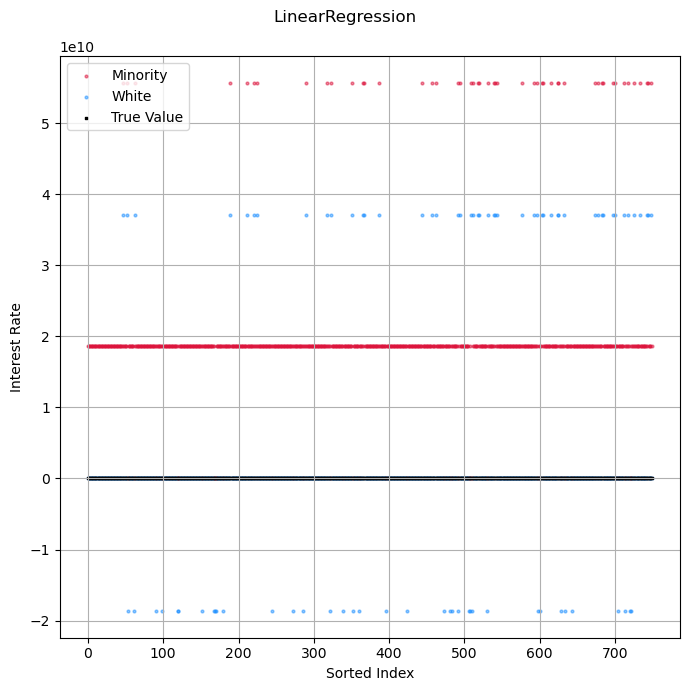

<Figure size 640x480 with 0 Axes>

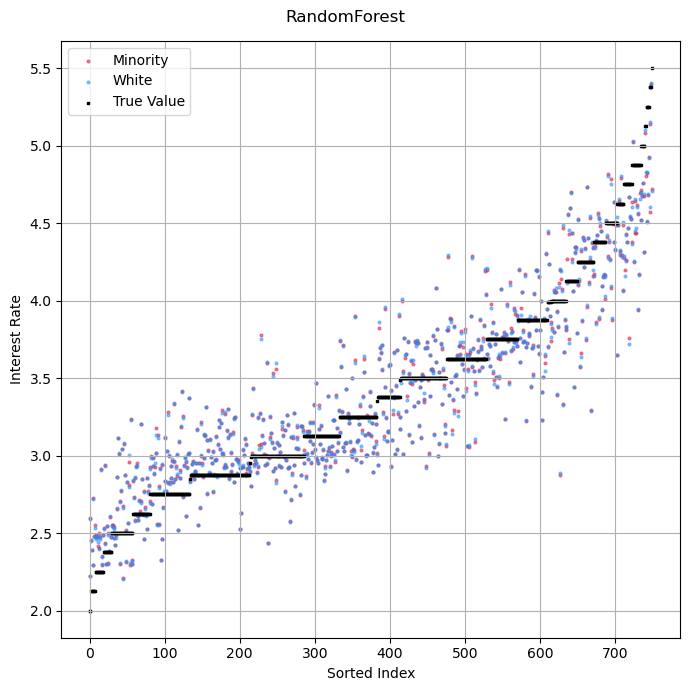

<Figure size 640x480 with 0 Axes>

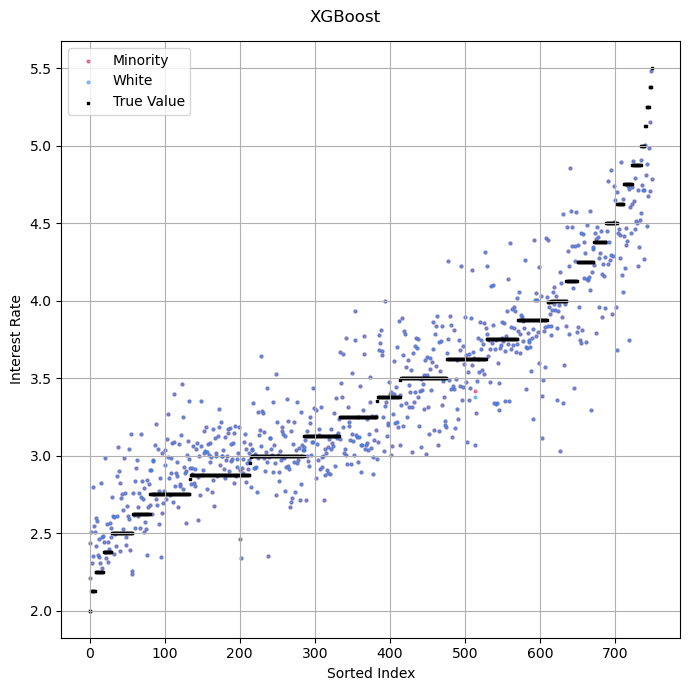

<Figure size 640x480 with 0 Axes>

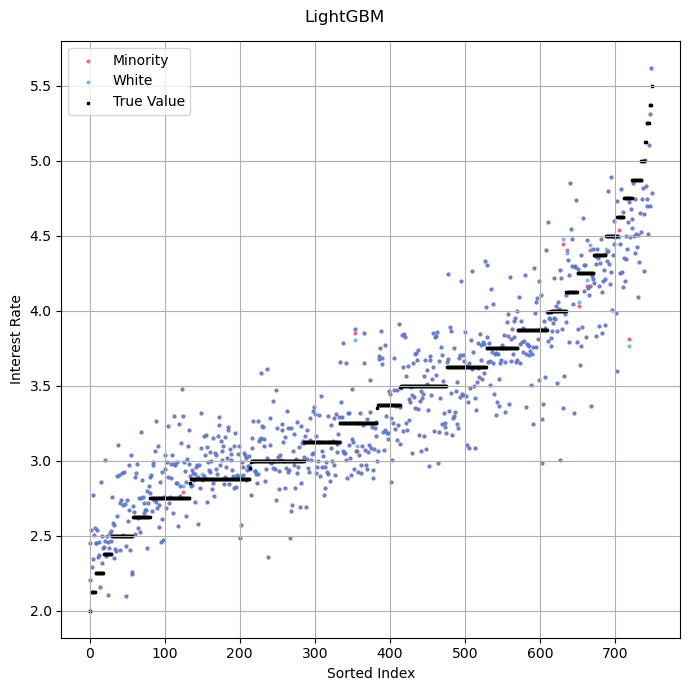

<Figure size 640x480 with 0 Axes>

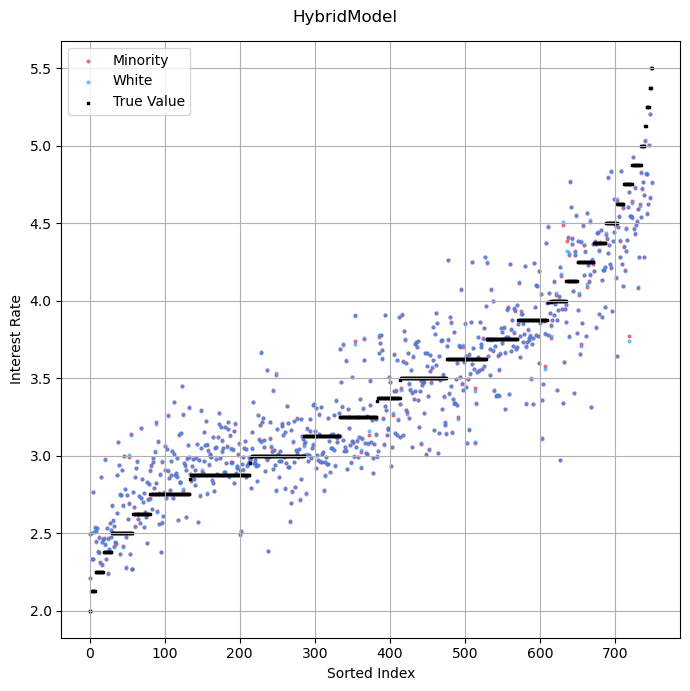

<Figure size 640x480 with 0 Axes>

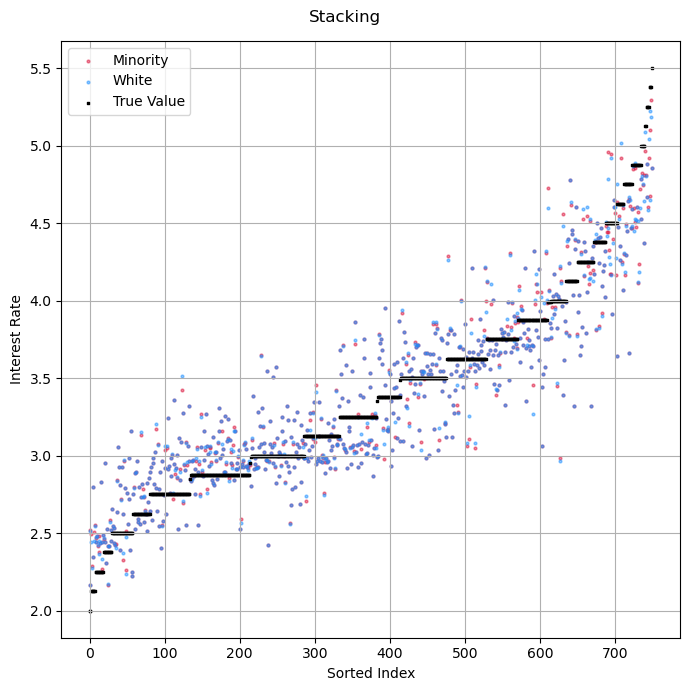

<Figure size 640x480 with 0 Axes>

In [35]:
create_subplots(models, y_preds, y_true, indices[:-1], colors, colors_true, titles)

For stacking, it is possible to identify some points that have higher interest rate predictions for minority applicants than for white applicants. This is especially true for the middle-high range of interest rates, suggesting that ethnicity plays a bigger role when the applicant is already belonging to a higher-risk category because of other factors than minority status.
At the same time, this trend is not always consistent, so no conclusions can be made.

### fare (df con y_min, y_white, differenza e poi) media differenza per tutti i modelli

In [27]:
import numpy as np
import pandas as pd
from scipy import stats

avg_diffs, ttests = [], []
diffs, t_statistic, p_value, pair, names = [], [], [], [], []

for i, model in enumerate(models):
    #print(model)
    y_pred = y_preds[i]
    avg_diffs.append([
        np.mean(np.array(y_pred[idx_min]) - np.array(y_pred[idx_white])),
        np.mean(np.array(y_pred[idx_min]) - np.array(y_pred[idx_miss])),
        np.mean(np.array(y_pred[idx_miss]) - np.array(y_pred[idx_white])),
        model ])
    
    # Perform t-tests
    for j in range(len(indices)):
        for k in range(j + 1, len(indices)):
            #print(j,k)
            diff = np.mean(np.array(y_pred[indices[j]]) - np.array(y_pred[indices[k]]))
            t_stat, p_val = stats.ttest_ind(y_pred[indices[j]], y_pred[indices[k]])
            t_statistic.append(t_stat)
            p_value.append(p_val)
            pair.append(str(titles[j])+'-'+str(titles[k]))
            names.append(model)
            diffs.append(diff)
    #ttests.append( [t_statistic, p_value, pair, [model]*3])

# Create a DataFrame for the average differences
avg_diffs_df = pd.DataFrame(avg_diffs, columns=['AvgDiff_Min_White', 'AvgDiff_Min_Miss', 'AvgDiff_Miss_White', 'Model'])
ttest_diffs_df = pd.DataFrame([diffs, t_statistic, p_value, pair, names], index=['Difference','t_statistic', 'p_value', 'Pair', 'Model'])#, columns=['T_Min_White', 'T_Min_Miss', 'T_Miss_White', 'Model'])


In [22]:
# Display the DataFrame
avg_diffs_df

,AvgDiff_Min_White,AvgDiff_Min_Miss,AvgDiff_Miss_White,Model
0,1.869147e+10,5.572669e+10,-3.703522e+10,LinearRegression
1,9.294029e-04,-5.494585e-04,1.478861e-03,RandomForest
2,4.611619e-05,4.611619e-05,0.000000e+00,XGBoost
3,-1.526969e-04,-1.526969e-04,0.000000e+00,LightGBM
4,2.742740e-04,-2.186797e-04,4.929538e-04,HybridModel
5,-6.076546e-04,-1.096976e-03,4.893214e-04,Stacking


In [16]:
ttest_diffs_df.T

,Difference,t_statistic,p_value,Pair,Model
0,18691467816.455189,35.366625,0.0,Minority-White,LinearRegression
1,55726687376.276451,105.441951,0.0,Minority-Missing,LinearRegression
2,37035219559.821274,70.075326,0.0,White-Missing,LinearRegression
3,0.000929,0.030337,0.975802,Minority-White,RandomForest
4,-0.000549,-0.017956,0.985677,Minority-Missing,RandomForest
5,-0.001479,-0.048281,0.961498,White-Missing,RandomForest
6,0.000046,0.001481,0.998819,Minority-White,XGBoost
7,0.000046,0.001481,0.998819,Minority-Missing,XGBoost
8,0.0,0.0,1.0,White-Missing,XGBoost
9,-0.000153,-0.004889,0.9961,Minority-White,LightGBM


In [17]:
# old graphs

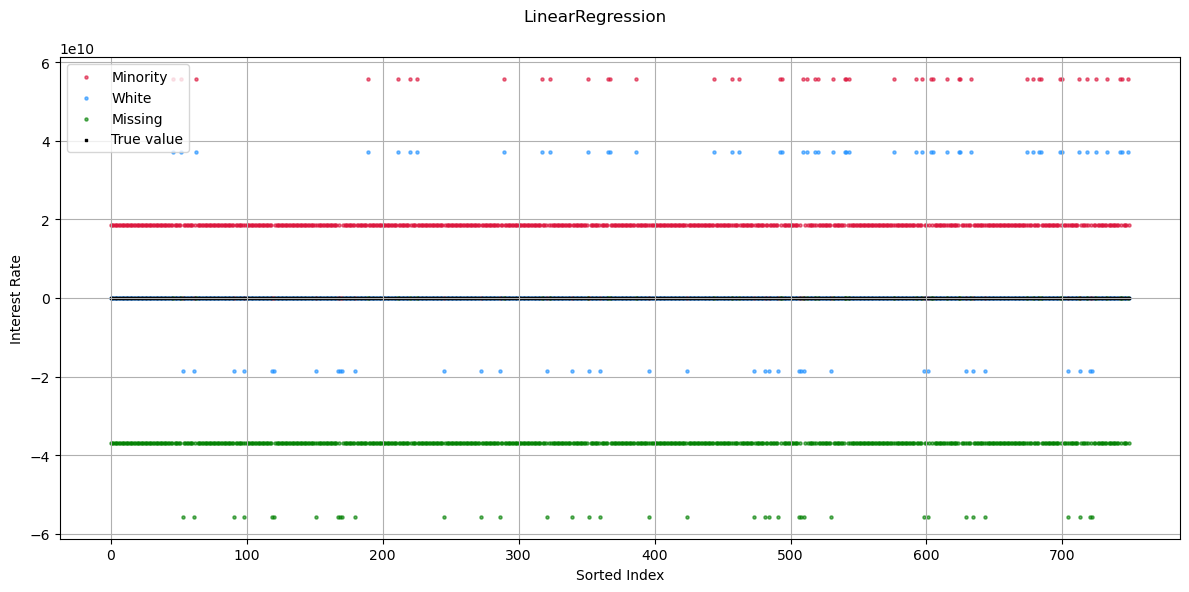

<Figure size 640x480 with 0 Axes>

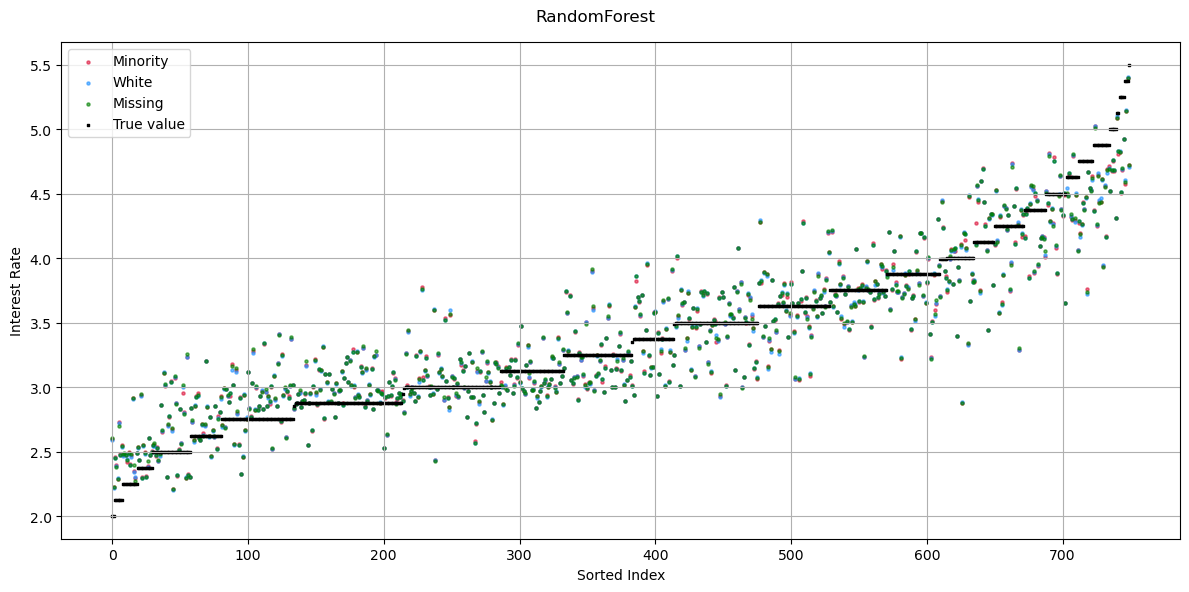

<Figure size 640x480 with 0 Axes>

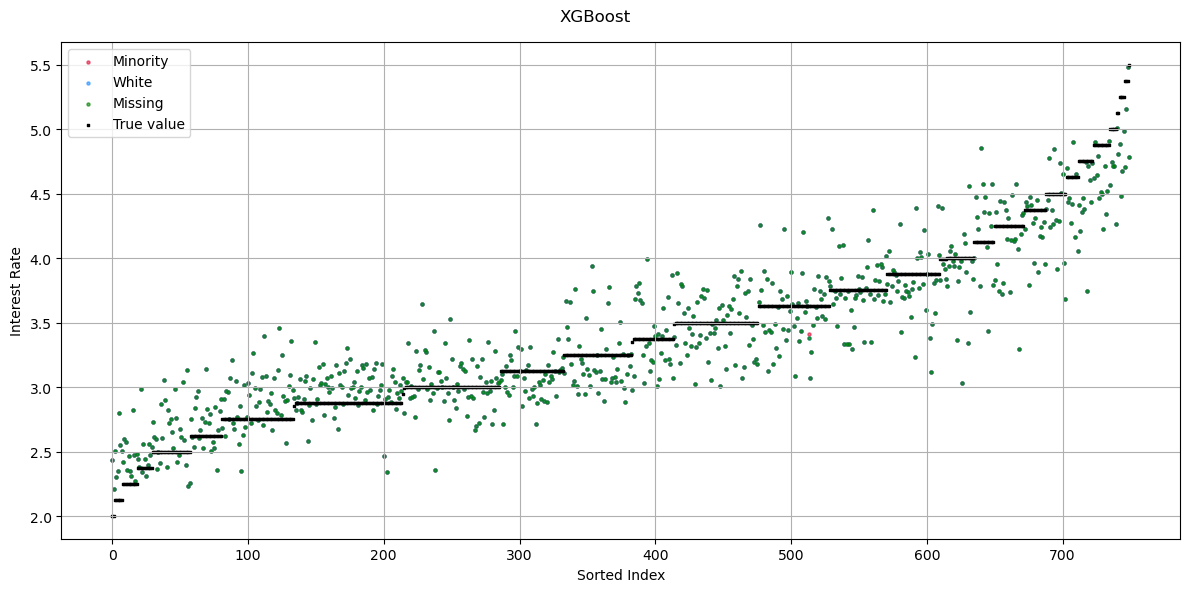

<Figure size 640x480 with 0 Axes>

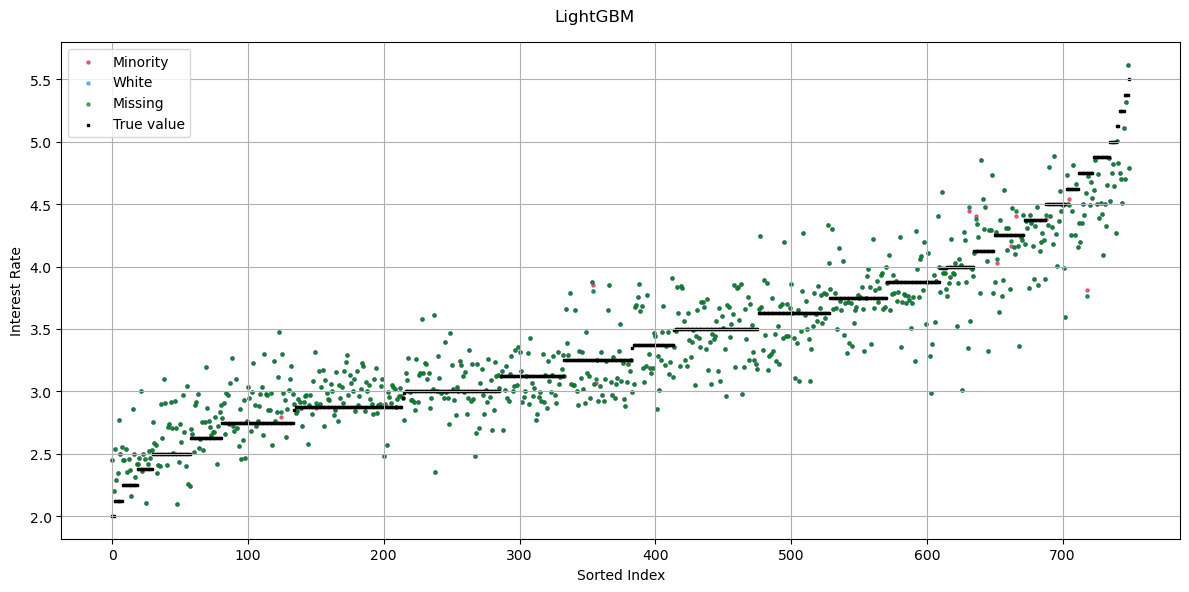

<Figure size 640x480 with 0 Axes>

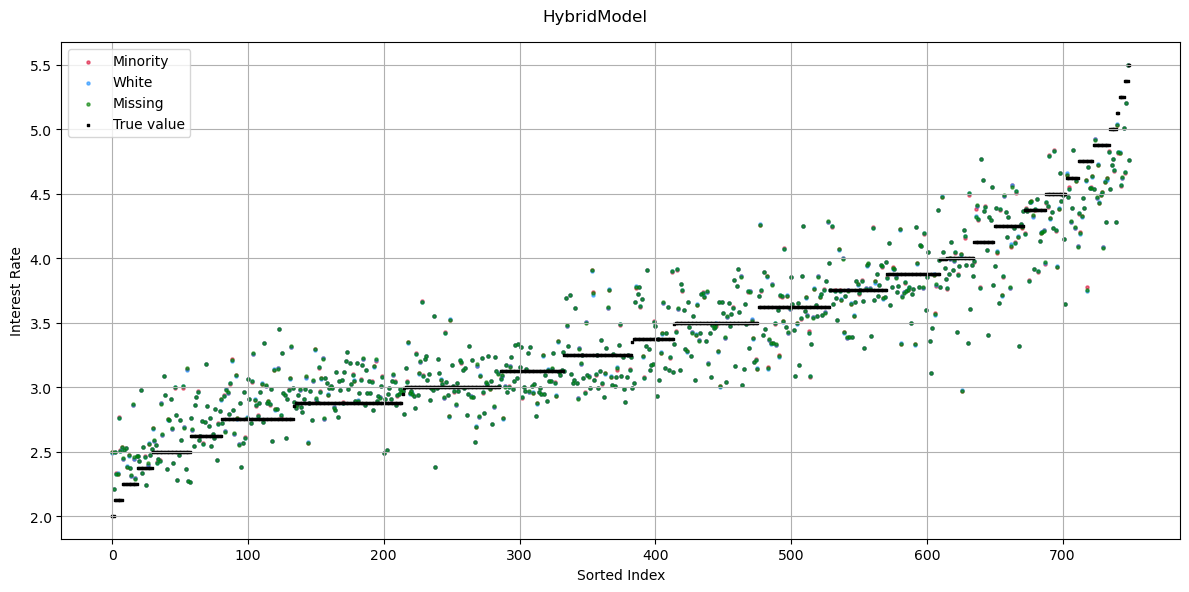

<Figure size 640x480 with 0 Axes>

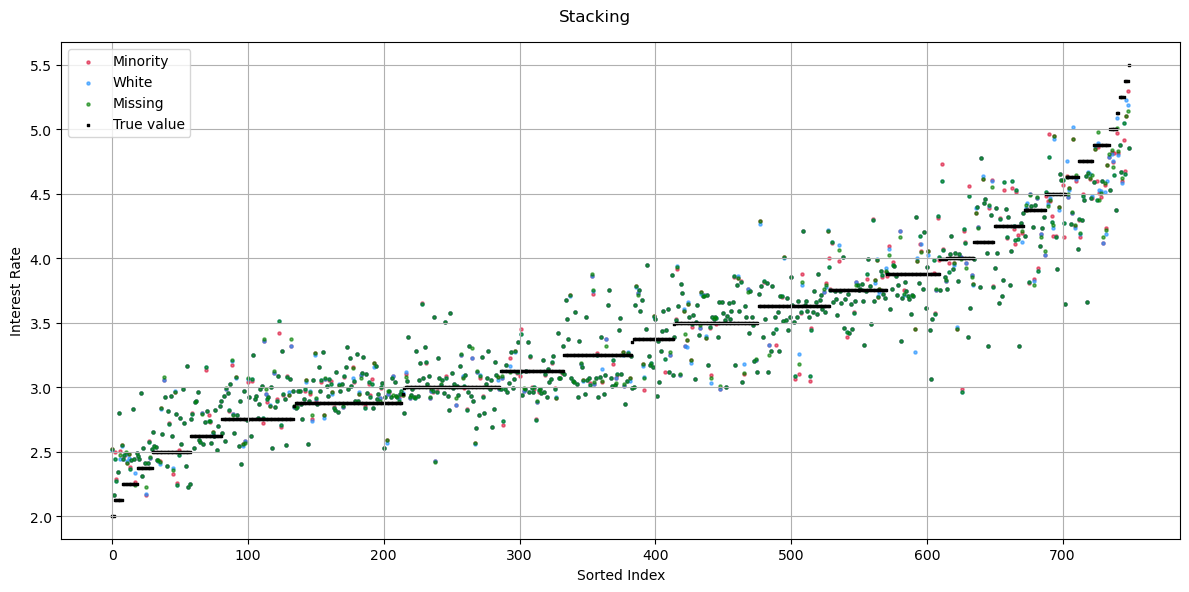

<Figure size 640x480 with 0 Axes>

In [18]:
for j, model in enumerate(models):
    y_pred = y_preds[j]
    
    
    plt.figure(figsize=(12, 6))
    plt.suptitle(model)

    # Create three subplots in a 1x3 grid
    for i, idx in enumerate(indices):
    
        y_pred_sel, y_true_sel = y_pred[idx], y_true[idx]

        # Sort the data and get the sorted indices
        sorted_indices = np.argsort(y_true_sel)

        # Sort y_true and y_pred based on the sorted indices
        y_true_sorted = np.array(y_true_sel)[sorted_indices]
        y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

        # Create a scatterplot
        plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=0.6, s=5)
        if i==2:
            plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='True value', alpha=1, s=3)
        plt.xlabel('Sorted Index')
        plt.ylabel('Interest Rate')
        #plt.title(titles[i])
        plt.legend(loc='upper left' )
        plt.grid(True)
        plt.tight_layout()

    plt.show()
    plt.clf()

0
1


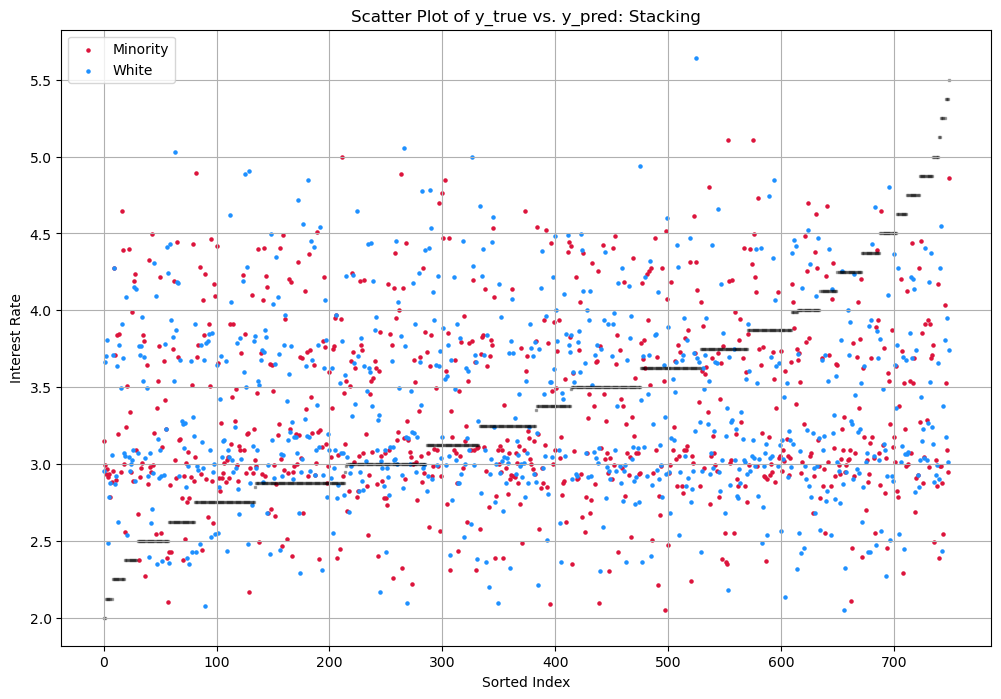

In [19]:
# VECCHIO !!!!
plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices[:-1]):    #idx_miss, 
    print(i)
    y_pred_sel, y_true_sel = y_pred[idx] , y_true[idx]
    
    # Sort the data and get the sorted indices
    sorted_indices = np.argsort(y_true_sel)

    # Sort y_true and y_pred based on the sorted indices
    y_true_sorted = np.array(y_true_sel)[sorted_indices]
    y_pred_sorted = np.array(y_pred_sel)[sorted_indices]

    # Create a scatterplot
    plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c=colors[i], marker='o', label=titles[i], alpha=1, s=5)
    
    plt.xlabel('Sorted Index')
    plt.ylabel('Interest Rate')
    plt.title('Scatter Plot of y_true vs. y_pred: '+ model)
    plt.legend()

# plot y_true    
plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='black', marker='s', label='y_true', alpha=0.3, s=3)    
# Show the plot
plt.grid(True)
plt.show()

In [20]:
stop

NameError: name 'stop' is not defined

# ---------------------------OLD---------------------------


# TODO: Models Selected

In [ ]:
models = ['LinearRegression', # TODO: ADD OTHER
          'RandomForest',
          'HybridModel'
         ]


# Helper functions

In [ ]:
def identify_cases(y_true, y_pred, threshold=0.25):
    """
    Identify four cases based on the comparison of y_pred and y_true with a threshold.
    Returns a dictionary containing four lists of indices for each case.
    """
    # Calculate the absolute difference between y_pred and y_true
    diff = y_pred - y_true

    # Create masks for the four cases
    mask_case1 = (diff <= - threshold)               # prediction far too low
    mask_case2 = (diff < 0) & (diff > - threshold)
    mask_case3 = (diff > 0) & (diff < threshold)
    mask_case4 = (diff >= threshold)                 # prediction far too high

    # Identify the indices for each case
    case1_indices = np.where(mask_case1)[0]
    case2_indices = np.where(mask_case2)[0]
    case3_indices = np.where(mask_case3)[0]
    case4_indices = np.where(mask_case4)[0]

    # Print the percentages of data points in each case
    n_y = len(y_pred)
    print(f"Case 1 (y_pred < y_true by at least {str(threshold)}): {mask_case1.sum()/n_y*100 :.3f}%")    # {z:.2f}
    print(f"Case 2 (y_pred < y_true by no more than {str(threshold)}): {sum(mask_case2)/n_y*100 : .2f}%")
    print(f"Case 3 (y_pred > y_true by no more than {str(threshold)}): {sum(mask_case3)/n_y*100 : .2f}%")
    print(f"Case 4 (y_pred > y_true by at least {str(threshold)}): {sum(mask_case4)/n_y*100 : .2f}%")

    # Create a dictionary to store the indices for each case
    cases = {
        '1': case1_indices,
        '2': case2_indices,
        '3': case3_indices,
        '4': case4_indices,
    }

    return cases

def add_cases(indexes, data_test, name_col='case'):
    data_test[name_col] = [1 if i in indexes['1'] else 2 if i in indexes['2'] 
                        else 3 if i in indexes['3'] else 4 if i in indexes['4'] else 0 
                           for i in range(len(data_test))]
    return data_test

# Predictions and Analysis

For each model, we first import the predictions and run analyses to uncover potential discriminations. 

## 1. PICK MODEL & visualize predictions vs true

In [ ]:
# CASES
model = models[2]    #for model in models:
y_pred = pd.read_csv(str(path)+str(model)+'_pred.csv', header=None)
y_pred = y_pred[0].values

In [ ]:
# Sort the data and get the sorted indices
sorted_indices = np.argsort(y_true)

# Sort y_true and y_pred based on the sorted indices
y_true_sorted = np.array(y_true)[sorted_indices]
y_pred_sorted = np.array(y_pred)[sorted_indices]

# Create a scatterplot
plt.figure(figsize=(9, 6))
plt.scatter(range(len(y_true_sorted)), y_pred_sorted, c='blue', marker='o', label='y_pred', alpha=0.3, s=5)
plt.scatter(range(len(y_true_sorted)), y_true_sorted, c='green', marker='s', label='y_true', alpha=0.3, s=5)
plt.xlabel('Sorted Index')
plt.ylabel('Interest Rate')
plt.title('Scatter Plot of y_true vs. y_pred: '+ model)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## 2.1 cases

In [ ]:
indexes = identify_cases(y_true, y_pred)

In [ ]:
data_test = add_cases(indexes, data_test, name_col=model)



# TODO: NUMERICAL VARIABLES
- for var in num_vars: if pvalue > 0.5 print "Found difference and plot box plots"



The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid.

The samples are independent.

Each sample is from a normally distributed population.

The population standard deviations of the groups are all equal. This property is known as homoscedasticity.

If these assumptions are not true for a given set of data, it may still be possible to use the Kruskal-Wallis H-test (scipy.stats.kruskal) or the Alexander-Govern test (scipy.stats.alexandergovern) although with some loss of power.

W. H. Kruskal & W. W. Wallis, “Use of Ranks in One-Criterion Variance Analysis”, Journal of the American Statistical Association, Vol. 47, Issue 260, pp. 583-621, 1952.



In [ ]:
numerical = pd.read_csv('../0_data/numerical.csv', index_col=0)['0'].values

In [ ]:
numerical

In [ ]:
counter, different_vars = 0, []
for var_name in numerical[1:]: 

    data = {'Group1': data_test.loc[indexes['1'],var_name].dropna().tolist(),
            'Group2': data_test.loc[indexes['2'],var_name].dropna().tolist(),
            'Group3': data_test.loc[indexes['3'],var_name].dropna().tolist(),
            'Group4': data_test.loc[indexes['4'],var_name].dropna().tolist()}
    
    # Perform ANOVA test
    h_statistic, p_value = stats.kruskal(data['Group1'], data['Group2'], data['Group3'], data['Group4'])    # f_oneway

    if p_value < 0.1: 
        counter +=1
        different_vars.append(var_name)
        print(f"\n\n{var_name}: found a statistical difference in the means, with p value: {p_value}\n") 
        
        
        # Perform pairwise KS tests
        data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        for i, dataset1 in enumerate(data):
            for j, dataset2 in enumerate(data):
                if i < j:
                    ks_statistic, p_value = stats.ks_2samp(dataset1, dataset2)
                    '''print(f"KS Test between Dataset {i+1} and Dataset {j+1}:")
                    print(f"KS Statistic: {ks_statistic}")
                    print(f"P-value: {p_value}")'''
                    if p_value < 0.05:  # Set your desired significance level
                        print(f"There is evidence of a difference in distributions between Dataset {i+1} and Dataset {j+1}")
                    else:
                        pass #print("No significant difference in distributions.\n")

        
        
        # plot box plots 
        #data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        plt.figure(figsize=(4, 4))
        plt.violinplot(data, showmedians=True, showmeans=False)#, labels=['Case 1', 'Case 2', 'Case 3', 'Case 4'])
        plt.xlabel("Groups")
        plt.ylabel("Values: "+var_name)
        plt.title("Comparison of Means among Multiple Groups: "+var_name)
        plt.show()
        

In [ ]:
print(f"Statistical difference in means found in {counter} variables: \n{different_vars}")

In [ ]:
data.head()


# TODO: CATEGORICAL VARIABLES
- add statistical test
- plot graph only if statistically significant numerical difference is detected

In [ ]:
categorical = pd.read_csv('../0_data/categorical_enc.csv', index_col=0)['0'].values

In [ ]:
for var_name in categorical:
    plt.figure(figsize=(4,3))
    ax = sns.countplot(x=model, data=data_test, hue=var_name) 
    plt.title(var_name) 
    plt.xlabel('Case')
    plt.legend(title=None)
    plt.show()

In [ ]:
counter, different_vars = 0, []
for var_name in categorical: 

    data = {'Group1': data_test.loc[indexes['1'],var_name].dropna().tolist(),
            'Group2': data_test.loc[indexes['2'],var_name].dropna().tolist(),
            'Group3': data_test.loc[indexes['3'],var_name].dropna().tolist(),
            'Group4': data_test.loc[indexes['4'],var_name].dropna().tolist()}
    
    # Perform ANOVA test
    h_statistic, p_value = stats.kruskal(data['Group1'], data['Group2'], data['Group3'], data['Group4'])    # f_oneway

    if p_value < 0.1: 
        counter +=1
        different_vars.append(var_name)
        print(f"\n\n{var_name}: found a statistical difference in the means, with p value: {p_value}\n") 
        
        
        # Perform pairwise KS tests
        data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        for i, dataset1 in enumerate(data):
            for j, dataset2 in enumerate(data):
                if i < j:
                    t_statistic, p_value = stats.ttest_ind(dataset1, dataset2)
                    '''print(f"KS Test between Dataset {i+1} and Dataset {j+1}:")
                    print(f"KS Statistic: {ks_statistic}")
                    print(f"P-value: {p_value}")'''
                    if p_value < 0.05:  # Set your desired significance level
                        print(f"There is evidence of a difference in distributions between Dataset {i+1} and Dataset {j+1}")
                    else:
                        pass #print("No significant difference in distributions.\n")

        
        plt.figure(figsize=(4,3))
        ax = sns.countplot(x=model, data=data_test, hue=var_name) 
        plt.title(var_name) 
        plt.xlabel('Case')
        plt.legend(title=None)
        plt.show()
        # plot box plots 
        #data = [data['Group1'], data['Group2'], data['Group3'], data['Group4']]
        '''plt.figure(figsize=(4, 4))
        plt.violinplot(data, showmedians=True, showmeans=False)#, labels=['Case 1', 'Case 2', 'Case 3', 'Case 4'])
        plt.xlabel("Groups")
        plt.ylabel("Values: "+var_name)
        plt.title("Comparison of Means among Multiple Groups: "+var_name)
        plt.show()'''
        

In [ ]:
print(f"Statistical difference in means found in {counter} variables: \n{different_vars}")